# Setting up Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

import numpy as np
import sys
import quandl
import math
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

import requests
import datetime
from datetime import datetime
import time
import pickle

C:\Users\jymas\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# quandl api - for Boeing EOD prices

qapi = 'https://www.quandl.com/api/v3/datasets/EOD/BA.json?api_key=AZ-XuMzaXBSCHuiyHusT'

# requesting from api

req = requests.get(qapi)
json_data = req.json()

# Using Quandl get

In [2]:
# raw dataframe from json data pulled

df_raw = quandl.get('EOD/BA',  authtoken='AZ-XuMzaXBSCHuiyHusT')

In [3]:
# refining dataframe - we only want to look at these columns

df_raw = df_raw[['Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Close', 'Adj_Volume']]

# additional columns

df_raw['HL_%'] = (df_raw['Adj_High'] - df_raw['Adj_Low'])/(df_raw['Adj_Low']) * 100 # % range of high-low intra-day prices
df_raw['% change'] = (df_raw['Adj_Close'] - df_raw['Adj_Open'])/(df_raw['Adj_Open']) * 100 # % increase in daily price

# filtering to create new df

df = df_raw[['Adj_Close', 'HL_%', '% change', 'Adj_Volume']]

df.fillna(value=-99999,inplace=True) # we don't want empty data

# forecast column created

forecast_col = 'Adj_Close'
forecast_out = int(math.ceil(0.002*len(df))) # predict 0.2% of the dataframe (for Boeing, ~29 days)
df['label'] = df[forecast_col].shift(-forecast_out)

C:\Users\jymas\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\jymas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [5]:
# creating X, y data for training

X = np.array(df.drop(columns=['label'])) # we want the machine to consider all data except the labels (that we will predict)

X = preprocessing.scale(X)
# scale new values alongside existing values - helps with training and testing,adds to processing time
# basically centers the entire dataset to the mean
    
X_lately = X[-forecast_out:] # last '29' days of X
X = X[:-forecast_out] # excludes recent '29' days of X

df.dropna(inplace=True)

y = np.array(df['label'])

# creating training data

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2) # 20% of data

# take our features and labels, shuffle, keeping x,y connected

# by defining the test size to be 0.2, this randomly defines 20% of our data (20% of features with associated labels)
# as testing data, and the remaining 80% as training data

# by doing so, we train our machine algorithm on 80% of the data, make a prediction for the remaining 20%
# then compare this to the original 20& we designated as testing data - this will give an accuracy test

C:\Users\jymas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [6]:
print('Length of training data - ' + str(len(y_train)) + ' and testing - ' + str(len(y_test)) + ' equals dataframe length - ' + str(len(df)))
print(str((len(y_train) + len(y_test)) == len(df)))

Length of training data - 11528 and testing - 2882 equals dataframe length - 14410
True


### Creating Training Method

In [7]:
# using Linear Regression algorithm from sklearn

clf = LinearRegression(n_jobs=-1) # as many jobs as possible (-1)
clf.fit(X_train, y_train) # training on x and y training values

with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f) # saving training method

### Defining Training Method

In [8]:
# calling the trained clf

pickle_in = open('linearregression.pickle', 'rb') # call the file
clf = pickle.load(pickle_in) # loading the pickled method from above file, assign to clf variable


accuracy = clf.score(X_test, y_test)

# testing the data - score takes X_test with expected y_test values
# predictions for X_test are made with clf (trained with Lin regression), then compared with expected y_test

# how accurate is this forecast tool

print(str(forecast_out) + ' days ahead with R^2 of ' + str(accuracy))

29 days ahead with R^2 of 0.9879297411018781


C:\Users\jymas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jymas\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


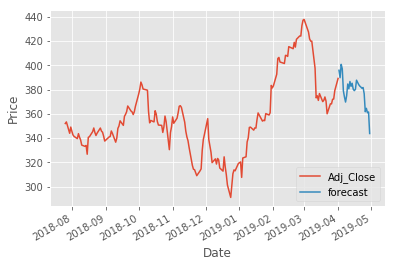

In [10]:
forecast_set = clf.predict(X_lately) # applying the prediction

df['forecast'] = np.nan

last_date = df.iloc[-1].name

last_unix = last_date.timestamp()

one_day = 86400 # seconds in day

next_unix = last_unix + one_day

# just adding all the forecasted values into the forecast column, while giving nan values for other columns

for i in forecast_set:
    next_date = datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
(df['Adj_Close'].iloc[-200:]).plot()
df['forecast'].plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Last 30 days 

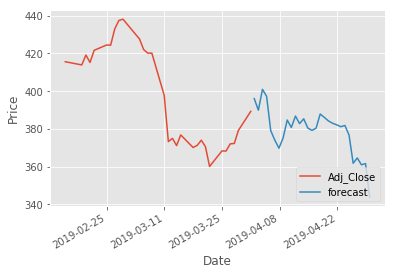

In [21]:
(df['Adj_Close'].iloc[-60:]).plot()
df['forecast'].plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [60]:
# alternative - using Epsilon-Support Vector Regression (SVR)

clf = svm.SVR(kernel='linear') # svm.SVR - support vector regression
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)

print(str(forecast_out) + ' days ahead with R^2 of ' + str(accuracy))

29 days ahead with R^2 of 0.9899730097490252
